# LAB 3.1 - TF model subclassing

In [1]:
!pip install tensorflow==2.15

In [2]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

In [34]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L03.01", varname="student");

logging in as jader.caro@udea.edu.co ... please wait

-------------
using course session 2021.deeplearning::udea.20242
success!! you are logged in
-------------


In [38]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.15.0'



**A multilayer perceptron**

assuming $n$ layers, the output at layer $i$

$$\mathbf{a}_i = \text{activation}(\mathbf{a}_{i-1} \cdot \mathbf{W}_i + \mathbf{b}_i)$$

at the first layer

$$\mathbf{a}_0 = \text{activation}(\mathbf{X} \cdot \mathbf{W}_0 + \mathbf{b}_0)$$

and the layer prediction is the output of the last layer:

$$\hat{\mathbf{y}} = \mathbf{a}_{n-1}$$

with $\text{activation}$ being an activation function, such as $\text{sigmoid}(z) = \frac{1}{1+e^{-z}}$, $\text{tanh}$, $\text{ReLU}$, etc.


**Cost (with regularization)**


$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \sum_{i=0}^{n-1} \bigg[ \| \mathbf{b}_i\|^2 + \|\mathbf{W}_i\|^2 \bigg]$$


$\lambda$ regulates the participation of the regularization terms. Given a vector or matrix $\mathbf{T}$, its squared norm is denoted by $||\mathbf{T}||^2 \in \mathbb{R}$ and it's computed by squaring all its elements and summing them all up.


## TASK 1: Model `build`

Observe the class template below which is used to build a multilayer perceptron with a specific number of layers. In the constructor.

- `neurons` must be a list of integers specifying the number of neurons of each hidden layer and the output layer.
- `activations` must be a list of strings specifying  the activations of the neurons of each layer.

Both `neurons` and `activations` must have the same number of elements. Observe how in the class constructor (`__init__`) we check for this and transform the list of activation strings to actual TF funcions.

**YOU MUST** complete the `build` method in the class below so that `self.W` and `self.b` contain a list of tensors with randomly initialized weights for each layer. Create the weights by calling the `self.add_weights` function for each layer, both for the weights (add them to list `self.W`) and the biases (add them to list `b`). Call `self.add_weights` with parameters `initializer='random_normal', trainable=True, dtype=tf.float32`.

Note that the shape of the first layer weights are not known until the `build` method is called which is when the `input_shape` for the input data is known. For instance, the following invokations


    >> mlp = MLP_class(neurons=[10,5,1], activations=["tanh","tanh", "sigmoid"])
    >> mlp.build([None, 2])
    >> print ("W shapes", [i.shape for i in mlp.W])
    
should produce the following output
    
    W shapes [TensorShape([2, 10]), TensorShape([10, 5]), TensorShape([5, 1])]
    b shapes [TensorShape([10]), TensorShape([5]), TensorShape([1])]

In [13]:
def MLP(neurons, activations, reg=0.):

    from tensorflow.keras import Model
    from tensorflow.keras.activations import relu, sigmoid, tanh, linear
    import numpy as np
    import tensorflow as tf

    class MLP_class(Model):
        def __init__(self, neurons, activations, reg=0.):
            super().__init__()
            self.activation_map = {"linear": linear, "relu": relu, "tanh":tanh, "sigmoid": sigmoid}

            assert len(neurons)==len(activations), \
                        "must have the same number of neurons and activations"

            assert np.alltrue([i in self.activation_map.keys() for i in activations]), \
                                "activation string not recognized"

            self.neurons = neurons
            self.reg = reg
            self.activations = [self.activation_map[i] for i in activations]

            super().__init__()

        def build(self, input_shape):
            self.W = []
            self.b = []

            for i in range(len(self.neurons)):
                shape = [input_shape[-1] if i==0 else self.neurons[i-1]] + [self.neurons[i]]
                self.W.append(self.add_weight(shape=shape, initializer='random_normal', trainable=True, dtype=tf.float32))
                self.b.append(self.add_weight(shape=[self.neurons[i]], initializer='random_normal', trainable=True, dtype=tf.float32))

    return MLP_class(neurons, activations, reg)


test manually your code

In [14]:
mlp = MLP(neurons=[10,5,1], activations=["tanh","tanh", "sigmoid"])
mlp.build([None, 2])
print ("W shapes", [i.shape for i in mlp.W])
print ("b shapes", [i.shape for i in mlp.b])

W shapes [TensorShape([2, 10]), TensorShape([10, 5]), TensorShape([5, 1])]
b shapes [TensorShape([10]), TensorShape([5]), TensorShape([1])]


<ipython-input-13-19cd5b357b99>:34: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  return MLP_class(neurons, activations, reg)


**Registra tu solución en linea**

In [15]:
student.submit_task(namespace=globals(), task_id='T1');

## Task 2: Model `call`

Complete the `call` method below so that it computes the output of the configured MLP with the input `X` as

$$\hat{\mathbf{y}} = \mathbf{a}_{n-1}$$

as described above. Use `self.W`, `self.b` and `self.activations` as constructed previously on the `build` and `__init__` methods.

In [24]:
def MLP2(neurons, activations, reg=0.):

    from tensorflow.keras import Model
    from tensorflow.keras.activations import relu, sigmoid, tanh, linear


    class MLP_class(Model):
        def __init__(self, neurons, activations, reg=0.):
            super().__init__()
            self.activation_map = {"linear": linear, "relu": relu, "tanh":tanh, "sigmoid": sigmoid}

            assert len(neurons)==len(activations), \
                        "must have the same number of neurons and activations"

            assert np.alltrue([i in self.activation_map.keys() for i in activations]), \
                                "activation string not recognized"

            self.neurons = neurons
            self.reg = reg
            self.activations = [self.activation_map[i] for i in activations]

            super().__init__()

        def build(self, input_shape):
            self.W = []
            self.b = []
            for i in range(len(self.neurons)):
                shape = [input_shape[-1] if i==0 else self.neurons[i-1]] + [self.neurons[i]]
                self.W.append(self.add_weight(shape=shape, initializer='random_normal', trainable=True, dtype=tf.float32))
                self.b.append(self.add_weight(shape=[self.neurons[i]], initializer='random_normal', trainable=True, dtype=tf.float32))


        @tf.function
        def call(self, X):
            a = X
            for i in range(len(self.neurons)):
                s = self.activations[i](tf.matmul(a, self.W[i])+self.b[i])
                a = s
            return s

    return MLP_class(neurons, activations, reg)

test manually your code, the following two cells must return the same value everytime you execute them. Observe your MLP will initialize to different random weights each time.

In [27]:
import numpy as np
import tensorflow as tf
X = np.random.random(size=(4,2))
neurons = [3,2]
mlp = MLP2(neurons=[3,2], activations=["linear", "sigmoid"])
mlp(X)

<ipython-input-24-d57310d14bae>:41: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  return MLP_class(neurons, activations, reg)


<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.51059526, 0.49381468],
       [0.51016045, 0.49335438],
       [0.51054394, 0.49380177],
       [0.5104745 , 0.49374926]], dtype=float32)>

In [28]:
sigm = lambda x: 1/(1+np.exp(-x))
W = [i.numpy() for i in mlp.W]
b = [i.numpy() for i in mlp.b]
sigm((X.dot(W[0])+b[0]).dot(W[1])+b[1])

array([[0.51059524, 0.49381467],
       [0.51016045, 0.4933544 ],
       [0.51054394, 0.49380175],
       [0.51047448, 0.49374928]])

**Registra tu solución en linea**

In [29]:
student.submit_task(namespace=globals(), task_id='T2');

## Task 3: Loss function

Complete the `loss` method below so that it computes the loss of the `MLP` given predictions `y_pred` (as the output of the network) and desired output `y_true`.

$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \sum_{i=0}^{n-1} \bigg[ \| \mathbf{b}_i\|^2_{mean} + \|\mathbf{W}_i\|^2_{mean} \bigg]$$


observe the regularization term $\lambda$ which is stored as `self.reg` in your class.

For any weight or bias $\mathbf{k}$, the expression $\| \mathbf{k}\|^2_{mean}$ is the mean of all its elements squared.

In [30]:
def MLP3(neurons, activations, reg=0.):

    from tensorflow.keras import Model
    from tensorflow.keras.activations import relu, sigmoid, tanh, linear

    class MLP_class(Model):
        def __init__(self, neurons, activations, reg=0.):
            super().__init__()
            self.activation_map = {"linear": linear, "relu": relu, "tanh":tanh, "sigmoid": sigmoid}

            assert len(neurons)==len(activations), \
                        "must have the same number of neurons and activations"

            assert np.alltrue([i in self.activation_map.keys() for i in activations]), \
                                "activation string not recognized"

            self.neurons = neurons
            self.reg = reg
            self.activations = [self.activation_map[i] for i in activations]

            super().__init__()

        def build(self, input_shape):
            self.W = []
            self.b = []
            for i in range(len(self.neurons)):
                shape = [input_shape[-1] if i==0 else self.neurons[i-1]] + [self.neurons[i]]
                self.W.append(self.add_weight(shape=shape, initializer='random_normal', trainable=True, dtype=tf.float32))
                self.b.append(self.add_weight(shape=[self.neurons[i]], initializer='random_normal', trainable=True, dtype=tf.float32))

        @tf.function
        def call(self, X):
            a = X
            for i in range(len(self.neurons)):
                s = self.activations[i](tf.matmul(a, self.W[i])+self.b[i])
                a = s
            return s


        @tf.function
        def loss(self, y_true, y_pred):
          mse = tf.reduce_mean(tf.square(y_true - y_pred))
          reg = self.reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in self.W]) + self.reg * tf.reduce_sum([tf.reduce_mean(tf.square(b)) for b in self.b])
          return mse + reg

    return MLP_class(neurons, activations, reg)

test manually your code, the following two cells must return the same value everytime you execute them. Observe your MLP will initialize to different random weights each time.

In [31]:
X = np.random.random(size=(4,2)).astype(np.float32)
y_true = np.random.randint(2, size=(len(X),1)).astype(np.float32)
neurons = [3,2]
mlp = MLP3(neurons=[3,1], activations=["linear", "sigmoid"], reg=0.2)
mlp.loss(mlp(X), y_true).numpy()

<ipython-input-30-ecdc4e62feaa>:46: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  return MLP_class(neurons, activations, reg)


0.245821

In [32]:
sigm = lambda x: 1/(1+np.exp(-x))
W = [i.numpy() for i in mlp.W]
b = [i.numpy() for i in mlp.b]
y_pred = sigm((X.dot(W[0])+b[0]).dot(W[1])+b[1])
((y_pred-y_true)**2).mean() + mlp.reg * np.sum([(i**2).numpy().mean() for i in mlp.W+mlp.b])

0.24582099374383687

**Registra tu solución en linea**

In [35]:
student.submit_task(namespace=globals(), task_id='T3');

## Done!!

now you can try your class with synthetic data

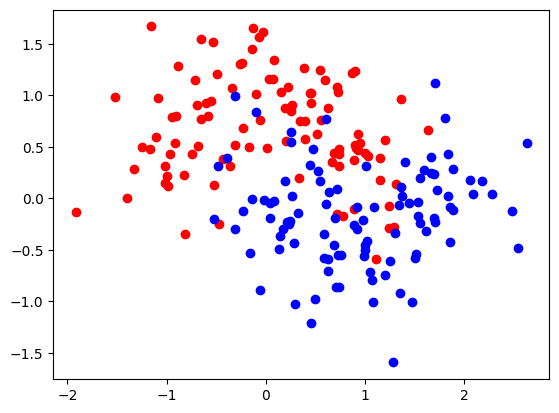

In [39]:

X, y = make_moons(200, noise=.35)
X, y = X.astype(np.float32), y.astype(np.float32).reshape(-1,1)
plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], color="red", label="class 0")
plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], color="blue", label="class 1")

create MLP and train!!

In [41]:
mlp_class = MLP
mlp = mlp_class(neurons=[10,1], activations=["tanh","sigmoid"], reg=0.0)
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
           metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])

<ipython-input-13-19cd5b357b99>:34: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  return MLP_class(neurons, activations, reg)


AttributeError: 'MLP_class' object has no attribute 'loss'

In [ ]:
!rm -rf logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/no_regularization")
mlp.fit(X,y, epochs=400, batch_size=16, verbose=0,
        callbacks=[tensorboard_callback])

observe the accuracy and classification frontier

In [ ]:
predict = lambda X: (mlp.predict(X)[:,0]>0.5).astype(int)
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1));
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));

regularization must work!!!

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/with_regularization")
mlp = MLP(neurons=[10,1], activations=["tanh","sigmoid"], reg=0.005)

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
           metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])

mlp.fit(X,y, epochs=400, batch_size=10, verbose=0, callbacks=[tensorboard_callback])
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1))
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));

and inspect tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
